# Feature identifiability with SAE representations

This notebook proposes a identifiability method based on linear regression to analyze the representations learned by SAE in audio foundation models. the aim of this study is to identify what acoustic features are better reconstructed with these sparse representations. We use egMaPS as acoustic features and LASSO regression.

In [ ]:
import pandas as pd
import os
from audxsae.eval.metrics import disentanglement_score, completeness_score

### Read the features for the current set

In [ ]:
path_to_features = "/lium/corpus/vrac/tmario/VocalSet/features/concat/test/features_egemaps_vocalset.csv"
all_feat = pd.read_csv(path_to_features)
all_feat.replace("tones_trillà","trillo",inplace=True)
all_feat.replace("tones_trill","trill",inplace=True)
all_feat.replace("tones_inhaled","inhaled",inplace=True)
all_feat.replace("tones_straight","straight",inplace=True)

In [3]:
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.pyplot as plt

generate_histograms = False

if generate_histograms:
    ignore_cols = ["audio_path", "name", "singer", "exercise_type", "vocal_technique", "vowel", "audio_id"]
    cols_to_plot = [col for col in all_feat.columns if col not in ignore_cols]

    with PdfPages("all_feat_histograms.pdf") as pdf:
        for col in cols_to_plot:
            plt.figure()
            all_feat[col].hist(bins=100)
            plt.title(col)
            plt.xlabel(col)
            plt.ylabel("Frequency")
            pdf.savefig()
            plt.close()

### Extract SAE representation for each layer in each model at each sparsity level

In [4]:
import h5py
import json 
import numpy as np

exp_root = "/lium/raid-b/tmario/train/SAE/ssl"
exp_list = os.listdir(exp_root)

exp_select = [f"{i:03d}" for i in range(6)] + [f"{i:03d}" for i in range(11,16)] + [f"{i:03d}" for i in range(21,35)]
print(exp_select)
exp_list = [e for e in exp_list if e.split('_')[0] in exp_select]
dataset = "vocalset"
exp_list = [e for e in exp_list if dataset in e]

['000', '001', '002', '003', '004', '005', '011', '012', '013', '014', '015', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034']


### To save representations if needed

In [5]:
save_rep = False

In [6]:
rep_dict = {
    "ast": {"sparsity": [], "hidden": [], "latent": [], "path": [], "labels": []},
    "wavlm": {"sparsity": [], "hidden": [], "latent": [], "path": [], "labels": []},
    "mert": {"sparsity": [], "hidden": [], "latent": [], "path": [], "labels": []},
    "hubert": {"sparsity": [], "hidden": [], "latent": [], "path": [], "labels": []},
}

for exp in exp_list:
    exp_id = exp.split("_")[0]
    exp_path = os.path.join(exp_root, exp)
    cfg_path = os.path.join(exp_path, "config.json")

    with open(cfg_path,"r") as fh:
        cfg = json.load(fh)

    model_type = cfg["model"]["encoder_type"]
    sparsity = cfg["model"]["sparsity"]
    files = os.listdir(exp_path)

    rep_file = os.path.join(exp_path,[f for f in files if f.startswith("extract_rep")][0])
    sae_rep = {}
    with h5py.File(rep_file, "r") as fh:
        for k in fh.keys():
            data = fh[k][()]
            sae_rep[k] = data

    rep_dict[model_type]["hidden"].append(sae_rep["hidden"])
    rep_dict[model_type]["latent"].append(sae_rep["latent"])
    rep_dict[model_type]["sparsity"].append(sparsity)
    rep_dict[model_type]["path"].append(sae_rep["path"])

labels = sae_rep["label"]
index_map = ['belt', 'breathy', 'inhaled', 'lip_trill', 'spoken', 'straight', 'trill', 'trillo', 'vibrato', 'vocal_fry']
if save_rep:
    import pickle
    class_labels = {"test_set_labels": labels, "label_map": index_map}
    with open(f"class_labels.pkl", "wb") as f:
        pickle.dump(class_labels, f)



In [7]:
def extract_all(full_feature_set: pd.DataFrame, sae_rep: np.array, input_act: np.array, idx_layer: int, paths: np.array):
    """match eGMAPS features with SAE representations for a givent dataset

    Args:
        full_feature_set (pd.DataFrame): dataframe containing the eGMAPS features for each file of the dataset (one line per file)
        sae_rep (np.array): array containing the SAE representaiotns extracted for each file 
        idx_layer (int): index of the layer to be used in the SAE representation
        paths (np.array): list of audio files to map the SAE representation with the features

    Returns:
        _type_: _description_
    """
    path_list = np.squeeze(paths)
    filename_list = [os.path.split(p.decode("utf-8"))[-1][:-4] for p in path_list]

    sae_act_stack = []
    input_act_stack = []
    feat_stack = []
    for index, row in full_feature_set.iterrows():
        audio_id = row["audio_id"]
        idx_rep = filename_list.index(audio_id)

        sae_activations = sae_rep[idx_rep,idx_layer,0,0,:]
        sae_input = input_act[idx_rep, idx_layer,0,0,:]

        sae_act_stack.append(sae_activations)
        input_act_stack.append(sae_input)

        audio_feat = row.drop(["audio_path", "name", "singer", "exercise_type", "vocal_technique", "vowel", "audio_id"], axis=0)
        audio_feat_np = audio_feat.to_numpy()

        feat_stack.append(audio_feat_np)

    sae_act_stack = np.array(sae_act_stack)
    feat_stack = np.array(feat_stack)
    input_act_stack = np.array(input_act_stack)

    return sae_act_stack, feat_stack, input_act_stack


from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

def fit_lasso(sae_latent_stack, feat_stack, min_dim_var=0):
    ignore_cols = ["audio_path", "name", "singer", "exercise_type", "vocal_technique", "vowel", "audio_id"]
    feature_labels = [col for col in all_feat.columns if col not in ignore_cols]
    clf = linear_model.Lasso(alpha=0.1,max_iter=10000)
    scaler = StandardScaler()
    
    X = sae_latent_stack
    y = feat_stack
    # dims_keep = np.sum(X, axis=0) > 0 
    X_norm = scaler.fit_transform(X)

    dims_keep = np.var(X_norm, axis=0) >= min_dim_var
    X_norm = X_norm[:,dims_keep]
    # print(f"INFO: {X_norm.shape[-1]} dims kept in SAE activations.")
    #normalize target features as well
    y_norm = scaler.fit_transform(y)
    n_feat = y_norm.shape[-1]

    lasso_dict = {}
    all_r2=[]
    weight_matrix = np.zeros((X_norm.shape[-1], y.shape[-1]))
    for idx_feat in range(n_feat):
        new_model = clone(clf)
        new_model.fit(X_norm, y_norm[:,idx_feat])
        score = new_model.score(X_norm, y_norm[:,idx_feat])
        lasso_dict[feature_labels[idx_feat]] = {"r2": score, "weights": new_model.coef_, "sparse_weights": new_model.sparse_coef_}
        weight_matrix[:,idx_feat] = np.abs(new_model.coef_)
        all_r2.append(score)

    return weight_matrix, all_r2, feature_labels

In [ ]:
from tqdm import tqdm
def sort_with_sparsity(rep, sparsity, act):
    rep = np.array(rep)
    sparsity = np.array(sparsity)
    act = np.array(act)
    idx_srt = np.argsort(sparsity)
    sparsity_srt = sparsity[idx_srt]
    rep_srt = rep[idx_srt,...]
    act_srt = act[idx_srt,...]
    return sparsity_srt, rep_srt, act_srt


layer_index_map = {
    "ast": [6, 12],
    "wavlm": [1, 12],
    "mert": [4, 7],
    "hubert": [3, 12]
}

def fit_all(rep_dict, full_feat_set, min_dim_var=0.0, select_top_feat:int=5, metric_to_sort: str = "r2"):

    results = []
    for model_type, reps in tqdm(rep_dict.items()):
        sparsity = reps["sparsity"]
        sae_hidden = reps["latent"]
        sae_input = reps["hidden"]

        sparsity_srt, sae_srt, input_srt = sort_with_sparsity(sae_hidden, sparsity, sae_input)
        path = np.array(reps["path"])[0,:,0]
        # print(f"{sparsity_srt.shape=}\n{sae_srt.shape=}\n{path.shape=}")
        layer_indexes = layer_index_map[model_type]
        for s, sae, input_act in zip(sparsity_srt, sae_srt, input_srt):
            for idx in range(len(layer_indexes)):
                sae_latent_stack, feat_stack, sae_input_stack = extract_all(full_feat_set, sae, input_act, idx_layer=idx, paths=path)
                dci_mat, r2_score, feature_labels = fit_lasso(sae_latent_stack, feat_stack, min_dim_var=min_dim_var)
                r2_score = np.array(r2_score)
                modularity, rho, mod_avg = disentanglement_score(dci_mat)
                completeness = np.squeeze(completeness_score(dci_mat))

                # print(f"{modularity.shape=}")
                # print(f"{completeness.shape=}")
                # print(f"{rho.shape=}")
                # print(f"{r2_score.shape=}")
                # print(f"{r2_score[np.argsort(r2_score)[:5]]=}")
                # print(f"{r2_score[np.flipud(np.argsort(r2_score))[:5]]=}")
                # print(f"{completeness[np.argsort(completeness)[:5]]=}")
                # print(f"{completeness[np.flipud(np.argsort(completeness))[:5]]=}")
                # average metrics on the top-10 factors (based on R2)
                if metric_to_sort == "r2":
                    top_fact_index = np.flipud(np.argsort(r2_score))[:select_top_feat]
                elif metric_to_sort == "comp":
                    top_fact_index = np.flipud(np.argsort(completeness))[:select_top_feat]
                top_r2 = r2_score[top_fact_index]
                top_comp = completeness[top_fact_index]
                feature_labels = np.array(feature_labels)
                
                results.append({
                        "model_type": model_type,
                        "sparsity": s,
                        "layer_index": layer_indexes[idx],
                        "dci": dci_mat,
                        "r2": r2_score,
                        'top_r2': top_r2,
                        'top_comp': top_comp,
                        'modularity': np.squeeze(modularity),
                        "completeness": completeness,
                        'mod_avg': mod_avg,
                        'top_feat_labels': feature_labels[top_fact_index],
                        'feat_labels': feature_labels,
                        'rho': np.squeeze(rho),
                        "sae_latent_set": sae_latent_stack,
                        "feature_set": feat_stack,
                        "original_latent_set": sae_input_stack})
                

    df = pd.DataFrame(results)
    return df, feature_labels 


In [10]:
import pickle
save_rep=False
if save_rep :
    df_res, feature_labels = fit_all(rep_dict=rep_dict, full_feat_set=all_feat, min_dim_var=0.0, select_top_feat=10)        
    with open(f"feature_labels.pkl", "wb") as f:
        pickle.dump(feature_labels, f)
    df_res.to_pickle("./df_res_r2.pkl")
else:
    df_res = pd.read_pickle("./df_res_r2.pkl")
    with open(f"./saved/feature_labels.pkl", "rb") as f:
        feature_labels = pickle.load(f)

In [ ]:
from audxsae.eval.utils import display_colored_top_features
display_colored_top_features(df_res, 1, "wavlm")
display_colored_top_features(df_res, 12, "wavlm")
# display_colored_top_features(df_res, 6, "ast")
# display_colored_top_features(df_res, 12, "ast")
# display_colored_top_features(df_res, 3, "hubert")
# display_colored_top_features(df_res, 12, "hubert")
# display_colored_top_features(df_res, 4, "mert")
# display_colored_top_features(df_res, 7, "mert")


/tmp/ipykernel_2256698/3372819005.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = matplotlib.cm.get_cmap('tab20', n_labels)


,model_type,sparsity,layer_index,top_feat_labels
12,wavlm,0.75,1,slopeV0-500_sma3nz_stddevNorm loudnessPeaksPerSec F0semitoneFrom27.5Hz_sma3nz_amean mfcc4_sma3_amean mfcc4V_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_percentile50.0 F3amplitudeLogRelF0_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_percentile80.0 mfcc3_sma3_amean HNRdBACF_sma3nz_amean
14,wavlm,0.80,1,F0semitoneFrom27.5Hz_sma3nz_amean loudnessPeaksPerSec mfcc4_sma3_amean mfcc4V_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_percentile50.0 F0semitoneFrom27.5Hz_sma3nz_percentile80.0 F0semitoneFrom27.5Hz_sma3nz_percentile20.0 F3amplitudeLogRelF0_sma3nz_amean mfcc3_sma3_amean mfcc3V_sma3nz_amean
16,wavlm,0.85,1,mfcc2V_sma3nz_stddevNorm mfcc4_sma3_stddevNorm slopeV0-500_sma3nz_stddevNorm loudnessPeaksPerSec F0semitoneFrom27.5Hz_sma3nz_amean mfcc4_sma3_amean mfcc4V_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_percentile50.0 F0semitoneFrom27.5Hz_sma3nz_percentile80.0 mfcc3V_sma3nz_amean
18,wavlm,0.90,1,loudnessPeaksPerSec F0semitoneFrom27.5Hz_sma3nz_amean mfcc4_sma3_amean F0semitoneFrom27.5Hz_sma3nz_percentile50.0 F0semitoneFrom27.5Hz_sma3nz_percentile80.0 mfcc4V_sma3nz_amean shimmerLocaldB_sma3nz_amean HNRdBACF_sma3nz_amean F3amplitudeLogRelF0_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_percentile20.0
20,wavlm,0.95,1,loudnessPeaksPerSec F0semitoneFrom27.5Hz_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_percentile50.0 mfcc4_sma3_amean F0semitoneFrom27.5Hz_sma3nz_percentile80.0 mfcc4V_sma3nz_amean F3amplitudeLogRelF0_sma3nz_amean HNRdBACF_sma3nz_amean shimmerLocaldB_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_percentile20.0
22,wavlm,0.99,1,loudnessPeaksPerSec F0semitoneFrom27.5Hz_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_percentile50.0 F0semitoneFrom27.5Hz_sma3nz_percentile80.0 mfcc4V_sma3nz_amean mfcc4_sma3_amean F0semitoneFrom27.5Hz_sma3nz_percentile20.0 mfcc3_sma3_amean mfcc3V_sma3nz_amean HNRdBACF_sma3nz_amean


/tmp/ipykernel_2256698/3372819005.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = matplotlib.cm.get_cmap('tab20', n_labels)


,model_type,sparsity,layer_index,top_feat_labels
13,wavlm,0.75,12,loudnessPeaksPerSec F2amplitudeLogRelF0_sma3nz_amean F3amplitudeLogRelF0_sma3nz_amean loudness_sma3_stddevNorm mfcc3_sma3_amean mfcc3V_sma3nz_amean F1amplitudeLogRelF0_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_percentile50.0 shimmerLocaldB_sma3nz_amean
15,wavlm,0.80,12,loudnessPeaksPerSec F2amplitudeLogRelF0_sma3nz_amean F3amplitudeLogRelF0_sma3nz_amean mfcc2V_sma3nz_stddevNorm mfcc3_sma3_amean loudness_sma3_stddevNorm F0semitoneFrom27.5Hz_sma3nz_amean mfcc3V_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_percentile50.0 F1amplitudeLogRelF0_sma3nz_amean
17,wavlm,0.85,12,mfcc1V_sma3nz_stddevNorm loudnessPeaksPerSec F2amplitudeLogRelF0_sma3nz_amean F3amplitudeLogRelF0_sma3nz_amean mfcc3V_sma3nz_amean mfcc3_sma3_amean F0semitoneFrom27.5Hz_sma3nz_amean loudness_sma3_stddevNorm F1amplitudeLogRelF0_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_percentile50.0
19,wavlm,0.90,12,mfcc4_sma3_stddevNorm loudnessPeaksPerSec F2amplitudeLogRelF0_sma3nz_amean mfcc3V_sma3nz_amean F3amplitudeLogRelF0_sma3nz_amean mfcc3_sma3_amean F0semitoneFrom27.5Hz_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_percentile50.0 loudness_sma3_stddevNorm mfcc4_sma3_amean
21,wavlm,0.95,12,mfcc4_sma3_stddevNorm loudnessPeaksPerSec F2amplitudeLogRelF0_sma3nz_amean F3amplitudeLogRelF0_sma3nz_amean mfcc3V_sma3nz_amean loudness_sma3_stddevNorm mfcc3_sma3_amean F0semitoneFrom27.5Hz_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_percentile50.0 mfcc4_sma3_amean
23,wavlm,0.99,12,loudnessPeaksPerSec F2amplitudeLogRelF0_sma3nz_amean mfcc3_sma3_amean loudness_sma3_stddevNorm mfcc3V_sma3nz_amean F3amplitudeLogRelF0_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_percentile50.0 F0semitoneFrom27.5Hz_sma3nz_amean F1amplitudeLogRelF0_sma3nz_amean F0semitoneFrom27.5Hz_sma3nz_percentile80.0


### Counting occurences of each feature category in the top-10 R2

In [ ]:
from audxsae.eval.utils import group_features
occ_feat = []
for ii, row in df_res.iterrows():
    top_feat_labels = row["top_feat_labels"].tolist()
    grouped_feats, occurences = group_features(top_feat_labels, num_top_feat=10)
    occurences["model_type"] = row["model_type"]
    occurences["layer_index"] = row["layer_index"]
    occurences["sparsity"] = row["sparsity"]
    occ_feat.append(occurences)

df_occ = pd.DataFrame(occ_feat)
# display(df_occ)


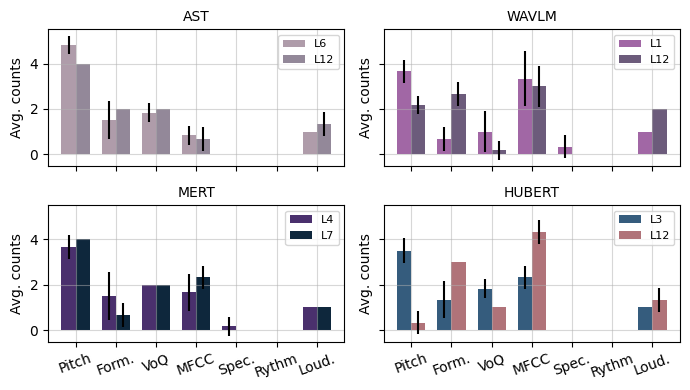

In [16]:
f, axs = plt.subplots(2,2,figsize=(7,4), layout='tight', sharex=True, sharey=True)
cats = [k for k in grouped_feats.keys()]

palette = [
    "#AF9CAA",  # muted lavender
    "#938899",  # light lavender 
    "#A167A5",  # purple
    "#6C5B7B",   # muted violet
    "#4A306D",  # deep purple
    "#0E273C",  # dark blue
    "#355C7D",  # blue-grey
    "#B07379",  # coral pink   
]
markers = ["o","d", "x", "+", "^", "v"]
idx_plt = [r for r in range(len(cats))]
axs_r = np.ravel(axs)
cats_short = ["Pitch", 'Form.', 'VoQ', 'MFCC', 'Spec.', 'Rythm', 'Loud.']
for im, model in enumerate(df_occ["model_type"].unique()):
    df_sel = df_occ.loc[df_occ["model_type"] == model]
    ax = axs_r[im]
    layer_indices = list(df_sel["layer_index"].unique())
    n_layers = len(layer_indices)
    bar_width = 0.35  # width of each bar
    x = np.arange(len(cats))
    for il, layer in enumerate(layer_indices):
        df_plt = df_sel.loc[df_sel["layer_index"] == layer]
        if not df_plt.empty:
            vals = df_plt[cats].agg(['mean','std'])
            sums = vals.loc["mean"].values
            stds = vals.loc["std"].values
            # Offset each layer's bars so they are side by side
            offset = (il - n_layers/2) * bar_width + bar_width/2
            ax.bar(x + offset, sums, width=bar_width, yerr=stds, color=palette[2*im + il], label=f"L{layer}")
            
    ax.set_ylabel('Avg. counts')
    ax.set_xticks(x)
    ax.set_xticklabels(cats_short, rotation=20)
    ax.set_title(f"{model.upper()}", fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.5)
f.savefig('./figs/top_r2_feat.pdf', transparent=True)
plt.show()



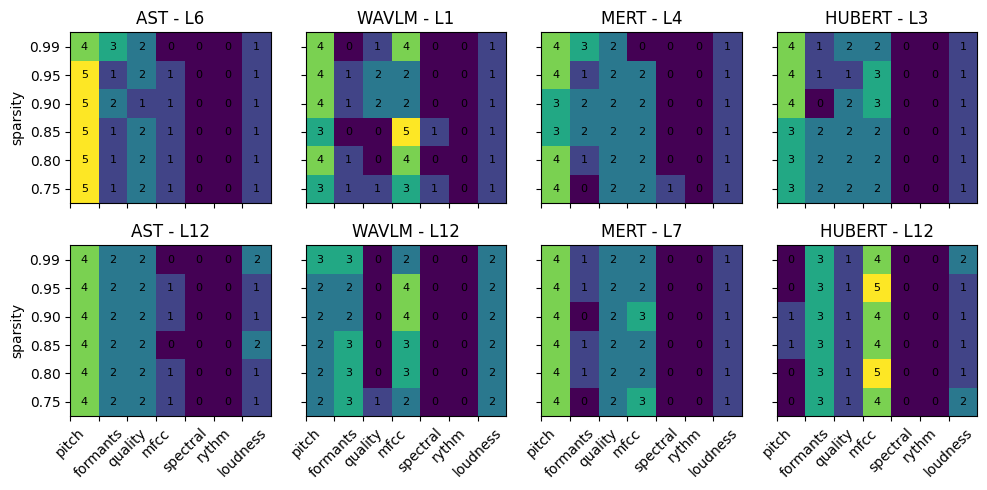

In [17]:
f, axs = plt.subplots(2,4,figsize=(10,5), layout='tight', sharex=True, sharey=True)
cats = [k for k in grouped_feats.keys()]

palette = [
    "#AF9CAA",  # muted lavender
    "#938899",  # light lavender 
    "#A167A5",  # purple
    "#6C5B7B",   # muted violet
    "#4A306D",  # deep purple
    "#0E273C",  # dark blue
    "#355C7D",  # blue-grey
    "#B07379",  # coral pink   
]
markers = ["o","d", "x", "+", "^", "v"]
idx_plt = [r for r in range(len(cats))]
# axs_r = np.ravel(axs)

for im, model in enumerate(df_occ["model_type"].unique()):
    df_sel = df_occ.loc[df_occ["model_type"] == model]
    ax = axs_r[im]
    layer_indices = list(df_sel["layer_index"].unique())
    n_layers = len(layer_indices)
    bar_width = 0.35  # width of each bar
    x = np.arange(len(cats))

    for il, layer in enumerate(layer_indices):
        df_plt = df_sel.loc[df_sel["layer_index"] == layer]
        sp = df_plt["sparsity"].unique()

        heatmap = np.zeros((len(sp), len(cats)))        
        for isp, s in enumerate(sp):
            # Offset each layer's bars so they are side by side
            heatmap[isp,:] = df_plt.loc[df_plt["sparsity"] == s][cats].values
            #offset = (il - n_layers/2) * bar_width + bar_width/2
            #ax.bar(x + offset, sums, width=bar_width, yerr=stds, color=palette[2*im + il], label=f"L{layer}")
    
        ax = axs[il, im]
        ax.pcolormesh(heatmap, vmin=0, vmax=5)
        if im == 0:
            ax.set_ylabel('sparsity')
        ax.set_xticks(x)
        ax.set_xticklabels(cats, rotation=45)
        ax.set_title(f"{model.upper()} - L{layer}")
        # Add values in each pixel of the pcolormesh plot
        for isp, s_val in enumerate(sp):
            for icat, cat in enumerate(cats):
                val = heatmap[isp, icat]
                ax.text(icat + 0.5, isp + 0.5, f"{val:.0f}", ha='center', va='center', color='black', fontsize=8)
        ax.set_yticks(np.arange(len(sp)) + 0.5)
        ax.set_yticklabels([f"{v:.2f}" for v in sp])
        # ax.legend(fontsize=8)
        # ax.grid(alpha=0.5)

plt.show()



### SAme but on completeness

In [18]:
import pickle
save_rep = False
if save_rep :
    df_res_c, feature_labels = fit_all(rep_dict=rep_dict, full_feat_set=all_feat, min_dim_var=0.0, select_top_feat=5, metric_to_sort="comp")        
    with open(f"feature_labels.pkl", "wb") as f:
        pickle.dump(feature_labels, f)
    df_res_c.to_pickle("./df_res_comp.pkl")
else:
    df_res_c = pd.read_pickle("./df_res_comp.pkl")
    with open(f"./saved/feature_labels.pkl", "rb") as f:
        feature_labels = pickle.load(f)

In [19]:
occ_feat = []
for ii, row in df_res_c.iterrows():
    top_feat_labels = row["top_feat_labels"].tolist()
    grouped_feats, occurences = group_features(top_feat_labels, num_top_feat=10)
    occurences["model_type"] = row["model_type"]
    occurences["layer_index"] = row["layer_index"]
    occurences["sparsity"] = row["sparsity"]
    occ_feat.append(occurences)

df_occ = pd.DataFrame(occ_feat)
# display(df_occ)


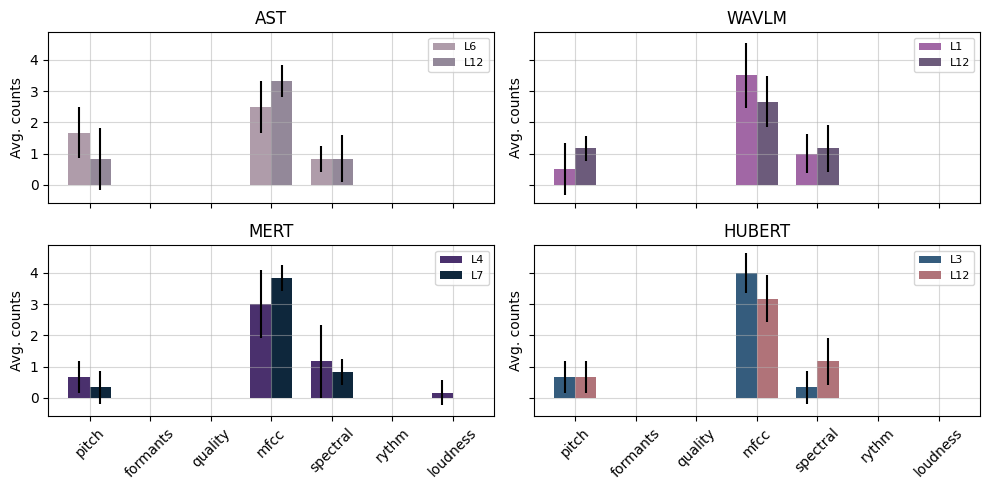

In [20]:
f, axs = plt.subplots(2,2,figsize=(10,5), layout='tight', sharex=True, sharey=True)
cats = [k for k in grouped_feats.keys()]

palette = [
    "#AF9CAA",  # muted lavender
    "#938899",  # light lavender 
    "#A167A5",  # purple
    "#6C5B7B",   # muted violet
    "#4A306D",  # deep purple
    "#0E273C",  # dark blue
    "#355C7D",  # blue-grey
    "#B07379",  # coral pink   
]
markers = ["o","d", "x", "+", "^", "v"]
idx_plt = [r for r in range(len(cats))]
axs_r = np.ravel(axs)

for im, model in enumerate(df_occ["model_type"].unique()):
    df_sel = df_occ.loc[df_occ["model_type"] == model]
    ax = axs_r[im]
    layer_indices = list(df_sel["layer_index"].unique())
    n_layers = len(layer_indices)
    bar_width = 0.35  # width of each bar
    x = np.arange(len(cats))
    for il, layer in enumerate(layer_indices):
        df_plt = df_sel.loc[df_sel["layer_index"] == layer]
        if not df_plt.empty:
            vals = df_plt[cats].agg(['mean','std'])
            sums = vals.loc["mean"].values
            stds = vals.loc["std"].values
            # Offset each layer's bars so they are side by side
            offset = (il - n_layers/2) * bar_width + bar_width/2
            ax.bar(x + offset, sums, width=bar_width, yerr=stds, color=palette[2*im + il], label=f"L{layer}")
            
    ax.set_ylabel('Avg. counts')
    ax.set_xticks(x)
    ax.set_xticklabels(cats, rotation=45)
    ax.set_title(f"{model.upper()}")
    ax.legend(fontsize=8)
    ax.grid(alpha=0.5)
plt.show()



### Factors completeness vs. entropy

In [21]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def entropy_histogram(data, bins=10):
    """Estimate entropy using histogram binning"""
    counts, _ = np.histogram(data, bins=bins)
    # Remove zero counts to avoid log(0)
    counts = counts[counts > 0]
    # Normalize to get probabilities
    probs = counts / np.sum(counts)
    # Calculate entropy
    return -np.sum(probs * np.log2(probs))

from sklearn.neighbors import NearestNeighbors
from scipy.special import digamma

def entropy_knn(data, k=3):
    """Estimate entropy using k-NN estimator (Kozachenko-Leonenko)"""
    n = len(data)
    data = data.reshape(-1, 1)
    
    # Fit k-NN
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(data)
    distances, _ = nbrs.kneighbors(data)
    
    # Distance to k-th nearest neighbor (excluding self)
    rk = distances[:, k]
    
    # Kozachenko-Leonenko estimator
    entropy = digamma(n) - digamma(k) + np.log(2) + np.mean(np.log(rk))
    return entropy / np.log(2)  # Convert to bits

In [22]:
ent_hist = {}
ent_knn = {}

for col in feature_labels:
    feat_set = all_feat[col].values
    H_hist = entropy_histogram(feat_set)
    H_knn = entropy_histogram(feat_set)

    ent_hist[col] = H_hist
    ent_knn[col] = H_knn





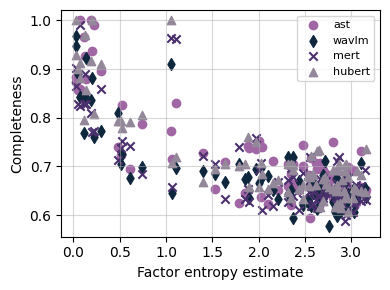

In [26]:
f, ax = plt.subplots(1,1,figsize=(4,3), layout='tight')
model_type = 'ast'
sparsity = 0.95

palette = [
    "#A167A5",
    "#0E273C",
    "#4A306D",
    "#938899", 
    "#AF9CAA",  # muted lavender
     # light lavender 
      # purple
    "#6C5B7B",   # muted violet
     # deep purple
      # dark blue
    "#355C7D",  # blue-grey
    "#B07379",  # coral pink   
]
markers = ["o","d", "x", "^", "^", "v"]

for kk,  model_type in enumerate(df_res_c["model_type"].unique()):
    if model_type == "ast":
        layer_index = 6
    elif model_type == "wavlm":
        layer_index = 1
    elif model_type == "hubert":
        layer_index = 3
    elif model_type == "mert":
        layer_index = 4

    df_select = df_res_c.loc[
        (df_res_c["model_type"] == model_type) 
        & (df_res_c["layer_index"] == layer_index) 
        & (df_res_c["sparsity"] == sparsity) 
    ]

    comp = df_select["completeness"].values
    if comp.shape[0] == 1:
        comp = comp[0]


    if kk == 0:
        features = df_select["feat_labels"].values[0]
    for ii, feat in enumerate(features):
        if ii == 0:
            ax.scatter(ent_hist[feat], comp[ii], marker=markers[kk], color=palette[kk], label=f'{model_type}')
        else:
            ax.scatter(ent_hist[feat], comp[ii], marker=markers[kk], color=palette[kk])
                       
ax.set_xlabel("Factor entropy estimate")
ax.set_ylabel("Completeness")
ax.grid(alpha=0.5)
ax.legend(fontsize=8)
f.savefig('./figs/comp_vs_entropy.pdf', transparent=True)
plt.show()

